In [1]:
#*** Load needed packages for analysis
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score, make_scorer
#from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn import cross_validation
#from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from scipy.sparse import hstack
import scipy.sparse as sp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.linear_model import SGDClassifier
import requests
#import psycopg2
from pandas import DataFrame
import pprint
import json
from pandas.io.json import json_normalize
from sqlalchemy import create_engine
from lxml import html
import requests
# from BeautifulSoup import BeautifulSoup, NavigableString, Tag

In [2]:
import random

import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm
import math
from scipy import sparse

def make_prediction(_val_x,_clf):
	prob = _clf.predict_proba(_val_x)
	prob = prob[:,1]
	return prob

def drop_features(tr_,val_,_vec,_selected_features):
	dcc = []
	for trx in _vec.vocabulary_:
		if trx not in _selected_features:
			dcc.append(_vec.vocabulary_[trx])
	tr_ = np.delete(tr_.toarray(), dcc, 1)
	tr_ = sparse.csr_matrix(tr_)
	val_ = np.delete(val_.toarray(), dcc, 1)
	val_ = sparse.csr_matrix(val_)
	return tr_ , val_, dcc

## Increased
Upload and split data into labels, text, and a copy of all data

In [3]:
increased_labeled = pd.read_csv('inc_ml_ready.csv',header=0,encoding='latin-1')
#******* Load LIWC
#LIWC = pd.read_csv('liwc.csv',header=0) # linguistic inquiry and word count analysis

In [4]:
increased_labeled = increased_labeled[increased_labeled['text'].notnull()]

y_is_relevant = increased_labeled['is_relevant'].tolist() # add to list

X_text = increased_labeled['text'].tolist()         #*** change format of the data for manipulation/processing (TRAINING)

increased_labeled_copy = increased_labeled[:] #*** make some copies for later use


# words/phrases

### Split up your data

In [5]:
print(f"labels: {increased_labeled.shape[0]}")

# calculate percent 1s in training
print(f"percent positive: {increased_labeled[(increased_labeled['is_relevant'] == '1')].shape[0] / 4568}")

labels: 4568
percent positive: 0.1771015761821366


#### Split: 80% training and 20% testing 

In [6]:
tr_data, te_data = train_test_split(increased_labeled, test_size=0.2, random_state=21)

#### Split: of that 20% testing data, split into 50% validation and 50% testing 
Validation (10%), testing (10%)

In [7]:
te_data, val_data = train_test_split(te_data, test_size=0.5, random_state=19)

In [8]:
print(f"training data shape: {tr_data.shape}")
print(f"test data shape: {te_data.shape}")
print(f"validation data shape: {val_data.shape}")

training data shape: (3654, 18)
test data shape: (457, 18)
validation data shape: (457, 18)


### Prep training data

In [9]:
# y train is 'is_relevant' category from tr_data
tr_y = tr_data['is_relevant'].tolist()

# text training data
text_tr = tr_data['text'].tolist() # text

#### clean training data
Convert all float-like and int-like strings to actual ints; else a typo in data and convert to 0

In [10]:
for i in range(len(tr_y)): 
    if tr_y[i] == '1.0' or tr_y[i] == '0.0':
        tr_y[i] = int(float(tr_y[i]))
    elif tr_y[i] == '1' or tr_y[i] == '0':
        tr_y[i] = int(tr_y[i])
    else:
        tr_y[i] = 0

### Prep test data

In [11]:
test_y = te_data['is_relevant'].tolist()
test_text = te_data['text'].tolist()

#### Clean Test Data
Convert all float-like and int-like strings to actual ints; else, a typo and convert to 0

In [12]:
for i in range(len(test_y)): 
    if test_y[i] == '1.0' or test_y[i] == '0.0':
        test_y[i] = int(float(test_y[i]))
    elif test_y[i] == '1' or test_y[i] == '0':
        test_y[i] = int(test_y[i])
    else:
        test_y[i] = 0

### Prep Validation Data

The validation set comes in to tell the program in the middle of its learning phrase to test if it’s doing the right thing. If it is not, and it keeps getting the predictions wrong in the validation set during the training phase, we know something is going wrong in the learning process and we can fix the necessary hyper-parameters. <br><br>

the goal is a classifier that generalizes to things it hasn't encountered

In [13]:
# val y is y validation data ('is_relevant'), from val_data
val_y = val_data['is_relevant'].tolist()

# text testing data 
text_val = val_data['text'].tolist() # text_test

### Clean val data
Convert all float-like and int-like strings to actual ints; else, a typo and convert to 0

In [14]:
for i in range(len(val_y)): 
    if val_y[i] == '1.0' or val_y[i] == '0.0':
        val_y[i] = int(float(val_y[i]))
    elif val_y[i] == '1' or val_y[i] == '0':
        val_y[i] = int(val_y[i])
    else:
        val_y[i] = 0

## Prediction 
Built from PAclassifier.py file <br>
Split 80/10/10: training set, validation set, test set <br>

### Proportion of positives in validation data?

In [15]:
val_y.count(1)/len(val_y)

0.3172866520787746

### Proportion of positives in training data?

In [16]:
tr_y.count(1)/len(tr_y)

0.2889983579638752

### Proportion of positives in testing data?

In [17]:
test_y.count(1)/len(test_y)

0.2844638949671772

### MDF + N GRAM
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html?highlight=tfidfvectorizer#sklearn.feature_extraction.text.TfidfVectorizer <br>

### TF-IDF VECTORIZER 
<p><b>for all data needed for training, validation, and testing</b></p>
<p>
<b>TF-IDF Vectorizer:</b> TF-IDF stands for “term frequency-inverse document frequency”, meaning the weight assigned to each token not only depends on its frequency in a document but also how recurrent that term is in the entire corpora. see: http://tfidf.com/ 

<b>MDF:</b> Minimum document frequency. When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If min_df =5, this means ignore terms that appear in less than 5 documents. If float in range of [0.0, 1.0], the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None. 

<b>ngram:</b> An ngram is a sequence built from words, and is a combination of words of n length. The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used. For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams. Only applies if analyzer is not callable.
</p>

In [18]:
def feature_preprocessing(_tr_data,_val_data,_te_data, _ngram, _mdf,feat_numbers=None):
	_vec= TfidfVectorizer(norm='l2', ngram_range=(1, _ngram), analyzer="word",min_df=_mdf, binary=False, encoding='latin-1', stop_words='english', max_features=feat_numbers)
	_tr_x_vect = _vec.fit_transform(_tr_data)
	_val_x_vect = _vec.transform(_val_data)
	_te_x_vect = _vec.transform(_te_data)
	return _tr_x_vect, _val_x_vect, _te_x_vect, _vec, feat_numbers

### Hyperparameter tuning

<b>precision</b> (a measure of quality) = true_pos / true_pos + false_pos <br>
Percentage of all predicted positives that are actually true positives. Higher precision means that an algorithm returns more relevant results than irrelevant ones. Optimize for precision where the cost of getting a prediction wrong is much higher than the cost of missing out on the right prediction.

<b>recall</b> (a measure of quantity) = true_pos / true_pos + false_neg <br>
Proportion of true positives to all relevant items. High recall means a return of most of the relevant results (whether or not irrelevant ones are also returned). Optimize for recall when the cost of missing a prediction is much higher than a wrong prediction.

<b>f1</b> = 2 x (precision x recall) / precision + recall <br>
The harmonic mean (calculated by dividing the number of observations by the reciprocal of each number in the series) of precision and recall. 

https://en.wikipedia.org/wiki/Precision_and_recall#/media/File:Precisionrecall.svg

In [19]:
def try_features():
    df = pd.DataFrame({'mdf':[], 'ngram':[], 'features':[], 'fscore':[]})
    
    for feat in range(100,20100,100): # iterate through features 100-20,000 increasing by 100
        for mdf in [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]: # iterate through mdf 1,2,3 (1-100, count by 5s; if too slow: 1, 5, 10, 20, 30, 40)
            for ngram in [1,2,3]: # iterate through ngram 1,2,3
                
                # feature preprocessing
                tr_x, val_x, _te_x_vect, vec, feat_numbers = feature_preprocessing(_tr_data=text_tr, _val_data=text_val, _te_data=test_text, _mdf=mdf, _ngram=ngram, feat_numbers=feat)
                
                # build classifier
                classifier = svm.SVC(kernel = 'linear',probability=True) #**** settings for the SVM machine
                classifier.fit(tr_x, tr_y)
                
                # make prediction
                probas = make_prediction(val_x, classifier)
                pred_y = [1 if probas[idx] >= 0.5 else 0 for idx in range(len(probas))]
                
                
                # get scores
                precision, recall, fscore, nada = precision_recall_fscore_support(val_y, pred_y, average='binary')
                
                new_row = {'mdf': mdf, 'ngram':ngram, 'features':feat, 'fscore':fscore}
                df = df.append(new_row, ignore_index=True)
    
    return df

In [169]:
features_df=try_features()

In [170]:
features_df.sort_values(by=['fscore'], ascending=False)

,mdf,ngram,features,fscore
6805,1.0,2.0,19000.0,0.529412
6769,1.0,2.0,18900.0,0.529412
7165,1.0,2.0,20000.0,0.523207
6337,1.0,2.0,17700.0,0.523207
7093,1.0,2.0,19800.0,0.523207
...,...,...,...,...
4497,100.0,1.0,12500.0,0.169697
6368,90.0,3.0,17700.0,0.169697
2613,60.0,1.0,7300.0,0.161491
6648,70.0,1.0,18500.0,0.160494


### Export features_df to CSV

In [194]:
compression_opts = dict(method='zip', archive_name='features_10_19_2020.csv')  
features_df.to_csv('features.zip', index=False, compression=compression_opts)  

In [59]:
features_df['mdf'] = features_df['mdf'].astype(int)
features_df['ngram'] = features_df['ngram'].astype(int)
features_df['features'] = features_df['features'].astype(int)

### make plots for each combination of mdf and ngram
features on x, fscore on y

In [171]:
import matplotlib
import matplotlib.pyplot as plt

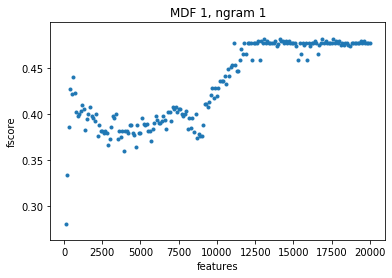

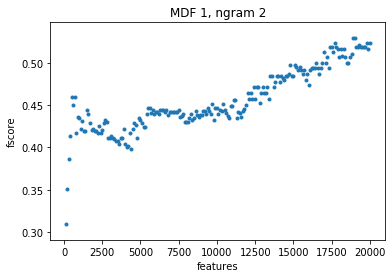

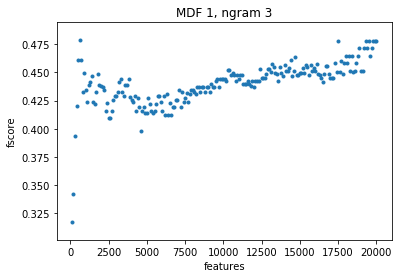

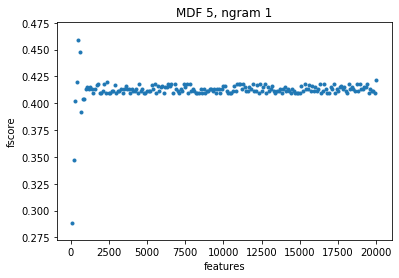

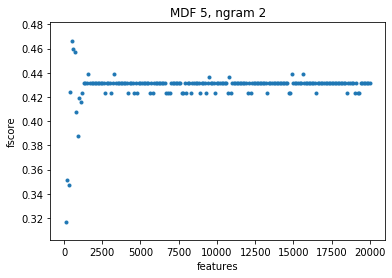

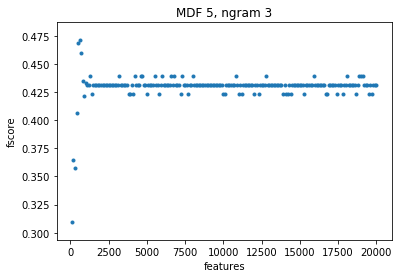

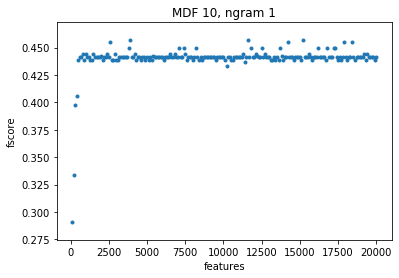

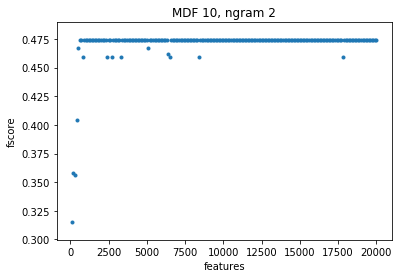

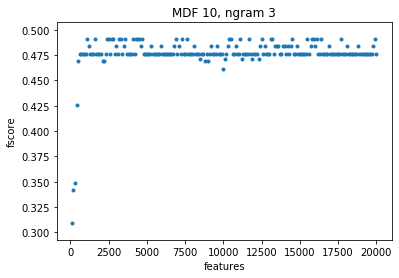

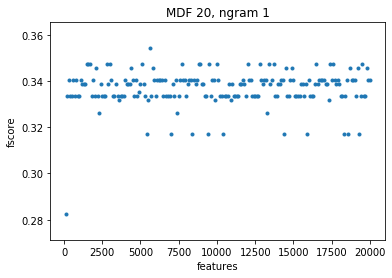

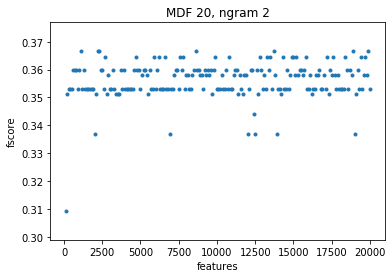

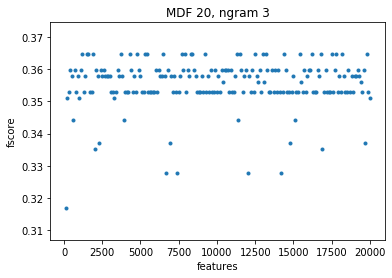

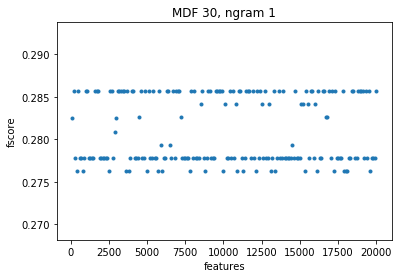

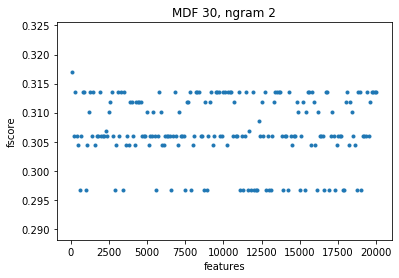

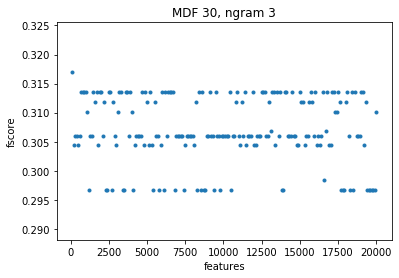

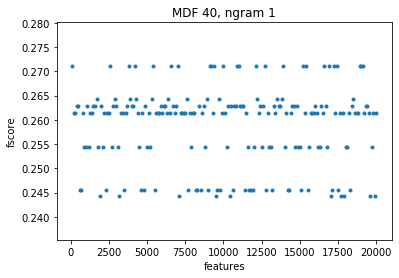

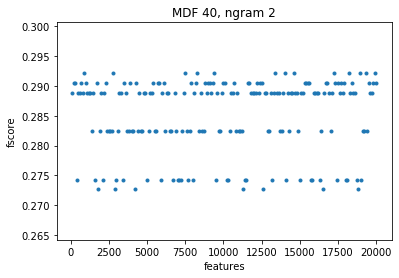

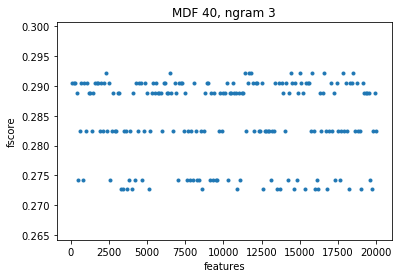

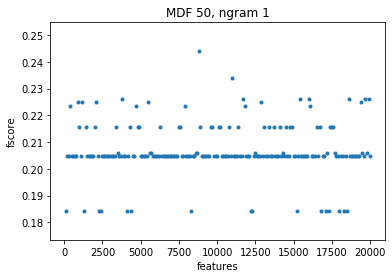

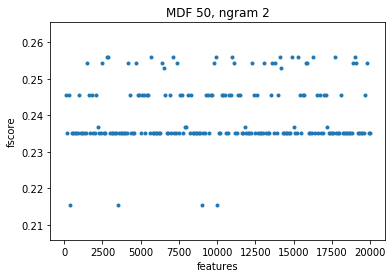

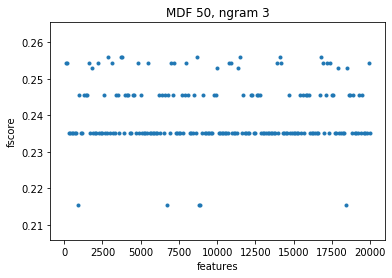

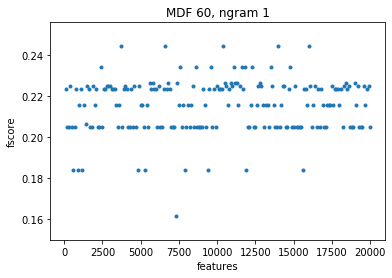

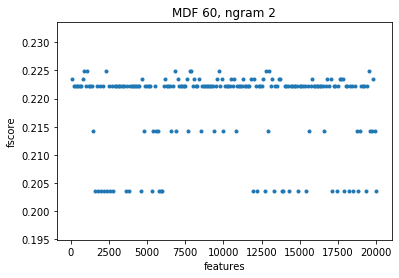

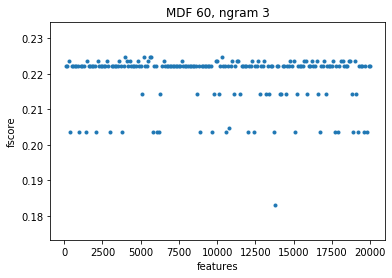

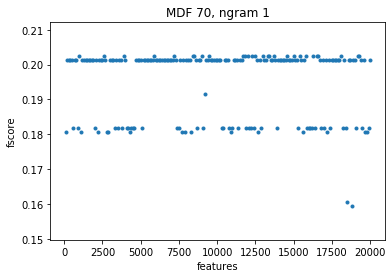

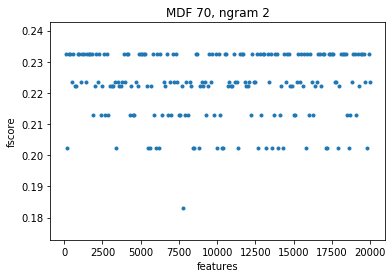

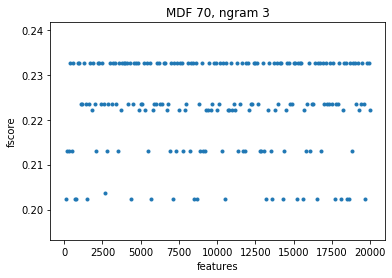

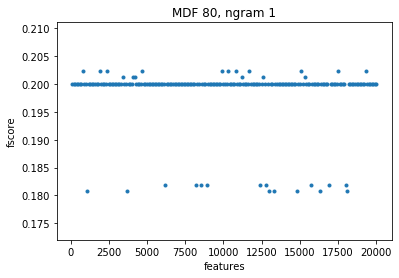

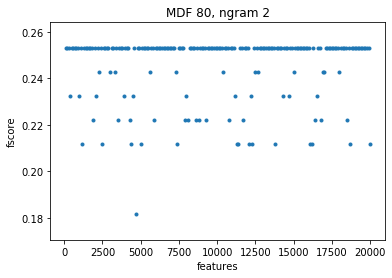

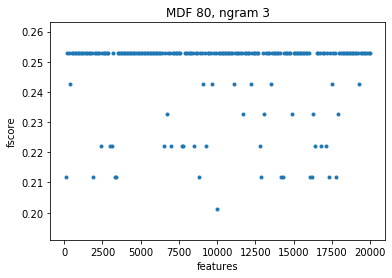

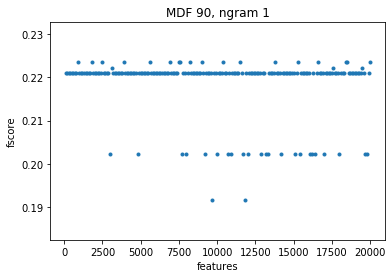

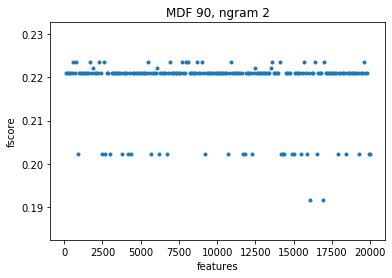

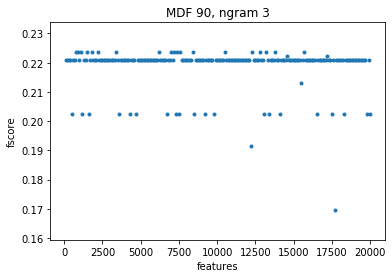

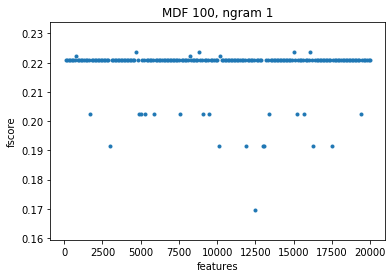

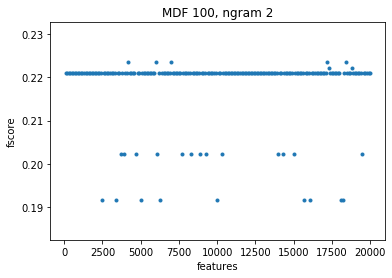

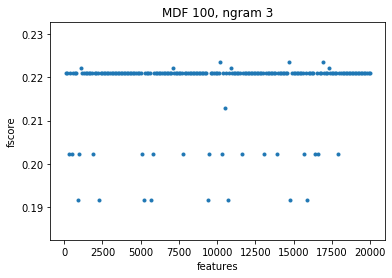

In [172]:
for mdf in [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    for ngram in [1, 2, 3]: 
        relevant_df = features_df[(features_df['mdf'] == mdf) & (features_df['ngram'] == ngram)]
        fig,ax=plt.subplots()

        ax.set_title(f'MDF {mdf}, ngram {ngram}')

        ax.scatter(relevant_df['features'], relevant_df['fscore'],marker='.')
        ax.set_xlabel("features")
        ax.set_ylabel("fscore")

        plt.show()

### Create the SVM Classifier based on performance from your top f1-score

precision = true positives/predicted positives <Br>
recall = true positives/actual positives <br>
f1score = 2*(Precision * Recall) / (Precision + Recall)

#### Try it out on validation data

In [20]:
tr_x, val_x, te_x, vect, feat_numbers = feature_preprocessing(_tr_data=text_tr, _val_data=text_val, _te_data=test_text, _mdf=1, _ngram=2, feat_numbers=19000)
                
# build classifier using training data
classifier = svm.SVC(kernel = 'linear',probability=True) #**** settings for the SVM machine
classifier.fit(tr_x, tr_y)
                
# make prediction on validation data using classifier
probas = make_prediction(val_x, classifier)
pred_y = [1 if probas[idx] >= 0.5 else 0 for idx in range(len(probas))]
                          
# get scores
precision, recall, fscore, nada = precision_recall_fscore_support(val_y, pred_y, average='binary')
print(f'precision: {precision}\n')
print(f'recall: {recall}\n')
print(f'fscore: {fscore}\n')

precision: 0.6774193548387096

recall: 0.43448275862068964

fscore: 0.5294117647058822



## What are the words picked up by vectorizer? 
check bag of words

In [21]:
feature_names = vect.get_feature_names()

In [22]:
weights = list(classifier.coef_.toarray()[0])

In [23]:
d = {'feat_name': feature_names, 'weight': weights}

weights_words_df = pd.DataFrame(data=d)

In [24]:
weights_words_df.sort_values(['weight'], ascending=False)

,feat_name,weight
1115,drinking,2.774903
8441,quarantine,2.448070
4961,netflix,2.386623
5323,night,2.214042
18872,zoom,2.055654
...,...,...
547,came,-1.034774
17806,wonder,-1.043712
16699,watching iâ,-1.087325
8823,reading,-1.129206


In [25]:
weights_words_df["abs_value"] = weights_words_df["weight"].apply(lambda x: abs(x))
weights_words_df["colors"] = weights_words_df["weight"].apply(lambda x: "green" if x > 0 else "red")
weights_words_df = weights_words_df.sort_values("abs_value", ascending=False)

### Find top 20 Features (based on absolute value)

In [295]:
import seaborn as sns

Text(0.5, 0, 'Feature Name')

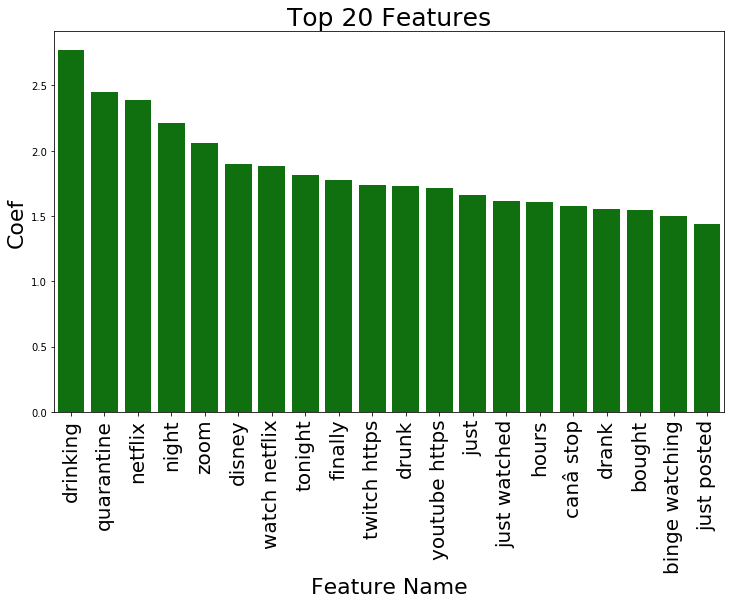

In [300]:
# https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feat_name",
            y="weight",
            data=weights_words_df.head(20),
           palette=weights_words_df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

### How does classifier perform on Training data?
This is a sanity check

In [183]:
train_probs = make_prediction(tr_x, classifier)

In [184]:
train_pred_y = [1 if train_probs[idx] >= 0.5 else 0 for idx in range(len(train_probs))]

#### Is there any basis for raising the threshold at which we will call something a 1 (e.g. ok to say we only want values above .7)?
We can treat this as a hyper parameter

#### Check precision, recall, fscore for train

In [185]:
precision, recall, fscore, nada = precision_recall_fscore_support(tr_y, train_pred_y, average='binary')
print('Prec: {} Recall: {} F1: {}'.format(precision,recall,fscore))

Prec: 0.9804772234273319 Recall: 0.8560606060606061 F1: 0.9140546006066734


#### Proportion of positives in training data?

In [159]:
tr_y.count(1)/len(tr_y)

0.2889983579638752

In [203]:
tr_y.count(0)

2598

### How does classifier perform on Test data?
This is the real test of the classifier's performance

In [26]:
test_probs = make_prediction(te_x, classifier)

In [27]:
test_pred_y = [1 if test_probs[idx] >= 0.5 else 0 for idx in range(len(test_probs))]

#### Check precision, recall, fscore for test

In [28]:
precision, recall, fscore, nada = precision_recall_fscore_support(test_y, test_pred_y, average='binary')
print('Prec: {} Recall: {} F1: {}'.format(precision,recall,fscore))

Prec: 0.65625 Recall: 0.4846153846153846 F1: 0.5575221238938053


## compare to naive classifier performance on testing data

### What is our baseline?
A baseline is a naive classifier. It can be predicting all 1s, or predicting based on most frequent values in training, among other options. This allows for assessment of how well our classifier works.

accuracy
precision = true_pos/true_pos + false_pos <br>
recall = true_pos / true_pos + false_neg <br>
f1score = 2*(Precision * Recall) / (Precision + Recall)<br>


In [29]:
from sklearn.dummy import DummyClassifier

### Constant strategy
A dummy classifier that predicts all test_y as positive

In [30]:
dummy_clf = DummyClassifier(strategy="constant", constant = 1)
dummy_clf.fit(tr_x, tr_y)
all_pos_y_pred = dummy_clf.predict(test_y)

In [31]:
# get scores
precision, recall, fscore, nada = precision_recall_fscore_support(test_y, all_pos_y_pred, average='binary')
print(f'precision: {precision}\n')
print(f'recall: {recall}\n')
print(f'fscore: {fscore}\n')
all_pos_precision = precision
all_pos_recall = recall
all_pos_fscore = fscore

precision: 0.2844638949671772

recall: 1.0

fscore: 0.44293015332197616



### Stratified method
generates predictions by respecting the training set’s class distribution.

In [32]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(tr_x, tr_y)
all_pos_y_pred = dummy_clf.predict(test_y)

In [33]:
# get scores
precision, recall, fscore, nada = precision_recall_fscore_support(test_y, all_pos_y_pred, average='binary')
print(f'precision: {precision}\n')
print(f'recall: {recall}\n')
print(f'fscore: {fscore}\n')
all_pos_precision = precision
all_pos_recall = recall
all_pos_fscore = fscore

precision: 0.2916666666666667

recall: 0.3230769230769231

fscore: 0.30656934306569344



### Uniform method
generates predictions uniformly at random

In [34]:
dummy_clf = DummyClassifier(strategy="uniform", constant = 1)
dummy_clf.fit(tr_x, tr_y)
all_pos_y_pred = dummy_clf.predict(test_y)

In [35]:
# get scores
precision, recall, fscore, nada = precision_recall_fscore_support(test_y, all_pos_y_pred, average='binary')
print(f'precision: {precision}\n')
print(f'recall: {recall}\n')
print(f'fscore: {fscore}\n')
all_pos_precision = precision
all_pos_recall = recall
all_pos_fscore = fscore

precision: 0.308411214953271

recall: 0.5076923076923077

fscore: 0.38372093023255816



### Let's see what the svm classifier predicted for Testing Data

In [189]:
test = pd.DataFrame({'text':[],'prediction':[], 'actual':[]})

In [190]:
test['text'] = test_text
test['prediction'] = test_pred_y
test['actual'] = test_y

In [196]:
test[(test['prediction'] == 1) & (test['actual'] == 1)]

,text,prediction,actual
11,"Just posted a photo @ Flint, Michigan https://...",1,1
18,@KurtBenkert wasnât it you that I saw tweet ...,1,1
21,Just posted a video @ BB'S DINER https://t.co/...,1,1
32,honestly this quarantine is chill.. Iâm home...,1,1
37,Just posted a photo @ Smokin Dealz https://t.c...,1,1
...,...,...,...
408,If your not watching the dope live streams tha...,1,1
424,Just posted a photo @ Soldier Sons https://t.c...,1,1
434,Check out my broadcast from my PlayStation 4! ...,1,1
437,This wine and this bubble bath bout to be love,1,1
